In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import os
import glob
import time
import datetime as dt
from netCDF4 import Dataset as nc_Dataset
from netCDF4 import date2num, num2date
import pandas as pd
import numpy as np
import math
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from FunctionsAndClasses.HRRR_URMA_Datasets_AllVars import *
from FunctionsAndClasses.SR_UNet_simple import *
from FunctionsAndClasses.DefineModelAttributes import *
from FunctionsAndClasses.StatObjectConstructor import *
from FunctionsAndClasses.utils import *

In [2]:
PREDICTOR_VARS = ["t2m"]
TARGET_VARS = ["t2m"]
TARG_VAR="t2m" #for smartinit - should match at least one entry in TARGET_VARS

In [3]:
varname_units_dict = {"t2m":"deg C",
                        "d2m":"deg C",
                        "pressurf":"Pa",
                        "u10m":"m/s",
                        "v10m":"m/s"}
        
        
varname_translation_dict = {"t2m":"t2m",
                            "d2m":"d2m",
                            "pressurf":"sp",
                            "u10m":"u10",
                            "v10m":"v10"}

smartinit_var_select_dict = {"t2m":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':2}}, 
                              "d2m":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':2}}, 
                              "sp":{'filter_by_keys':{'typeOfLevel': 'surface'}},
                              "u10":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':10}},
                              "v10":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':10}}}

In [4]:
model_1_attrs = DefineModelAttributes(is_train=False)

### Change as needed
model_1_attrs.predictor_vars = PREDICTOR_VARS
model_1_attrs.target_vars = TARGET_VARS

model_1_attrs.create_save_name()
model_1_attrs.create_dataset()

Making dataset for model BS256_NE1000_tD_pred(t2m)_targ(t2m)
Terrain normalization done for ['diff']
Loading predictor dataset for t2m (Year = 2024, months = 1 to 12, hours = all)
Predictor dataset data loaded. Time taken = 14.7 sec
Normalizing over all times
Normalization done. Time taken = 22.5 sec
Loading target dataset for t2m (Year = 2024, months = 1 to 12, hours = all)
Target dataset data loaded. Time taken = 7.6 sec
Normalizing over all times
Normalization done. Time taken = 10.1 sec
DATASET CONSTRUCTION DONE


In [5]:
model_1 = SR_UNet_simple(n_channels_in=model_1_attrs.num_channels_in, n_channels_out=model_1_attrs.num_channels_out)
device = torch.device("cuda")
model_1.to(device)
model_1.load_state_dict(torch.load(f"/scratch/RTMA/alex.schein/CNN_Main/Trained_models/MAE_Loss/{model_1_attrs.savename}.pt", weights_only=True))

<All keys matched successfully>

In [6]:
statsobj_model_1 = ConstructStatObject(is_smartinit=False, current_model_attrs=model_1_attrs, target_var=TARG_VAR)
statsobj_model_1.trained_models_directory = f"/scratch/RTMA/alex.schein/CNN_Main/Trained_models/MAE_Loss"

statsobj_model_1.calc_domain_avg_RMSE_alltimes()

Calculating RMSE for all times (t2m, BS256_NE1000_tD_pred(t2m)_targ(t2m))
0% done
5% done
10% done
15% done
20% done
25% done
30% done
35% done
40% done
45% done
50% done
55% done
60% done
65% done
70% done
75% done
80% done
85% done
90% done
95% done
100% done


In [7]:
statsobj_smartinit = ConstructStatObject(is_smartinit=True, target_var=TARG_VAR)
statsobj_smartinit.calc_domain_avg_RMSE_alltimes()

t2m RMSE data for Smartinit exists on disk
t2m RMSE data has been read in


In [8]:
IDX = 1200
pred, targ, model_1_output, dt_current = get_model_output_at_idx(model_attrs=model_1_attrs, model=model_1, idx=IDX, pred_var=TARG_VAR, targ_var=TARG_VAR)

dt_current

datetime.datetime(2024, 2, 20, 0, 0)

In [9]:
dt.date.strftime(dt_current, "%Y-%m-%d %H")

'2024-02-20 00'

In [10]:
FORECAST_LEAD_HOURS=1

xr_smartinit = get_smartinit_output_at_idx(IDX, 
                                           dt_current-dt.timedelta(hours=FORECAST_LEAD_HOURS),  
                                           FORECAST_LEAD_HOURS, 
                                           smartinit_var_select_dict, 
                                           varname_translation_dict, 
                                           TARG_VAR)

In [11]:
maxtemp = np.max([np.max(pred.squeeze()), 
                  np.max(targ.squeeze()), 
                  np.max(model_1_output.squeeze()),
                  np.max(xr_smartinit.data)])-273.15

mintemp = np.min([np.min(pred.squeeze()), 
                  np.min(targ.squeeze()), 
                  np.min(model_1_output.squeeze()),
                  np.min(xr_smartinit.data)])-273.15

avg = (maxtemp-mintemp)/5 #Denominator chosen arbitrarily; adjust if needed

In [12]:
rmse_diff = np.array(statsobj_smartinit.domain_avg_rmse_alltimes_list) - np.array(statsobj_model_1.domain_avg_rmse_alltimes_list)
window_len = 24

In [13]:
tmp_str = dt.date.strftime(dt_current, "%b. %d, %H")
DATE_STR = f"{tmp_str} UTC" #f string hates defining datetime in { } ...

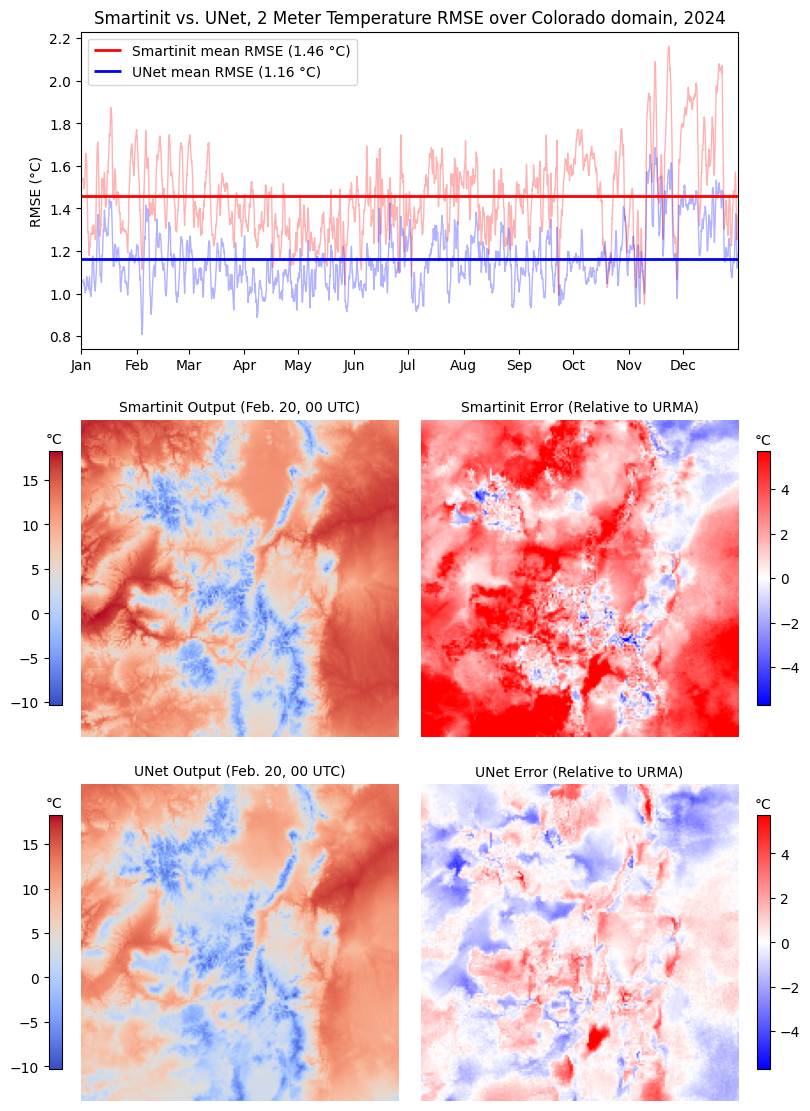

In [14]:
fig = plt.figure(figsize = (8,11), layout="constrained")
gs = gridspec.GridSpec(3,2, figure=fig, hspace=0.08, wspace=-0.2)

ax1 = fig.add_subplot(gs[0,:])
ax1.plot(model_1_attrs.dataset_date_list[window_len-1:], 
         rolling_avg(np.array(statsobj_smartinit.domain_avg_rmse_alltimes_list), window_len), 
         linewidth=1, 
         color="r", 
         alpha=0.3)#, label=f"Smartinit RMSE, rolling {window_len}-hr mean")

ax1.plot(model_1_attrs.dataset_date_list[window_len-1:], 
         rolling_avg(np.array(statsobj_model_1.domain_avg_rmse_alltimes_list), window_len), 
         linewidth=1, 
         color="b", 
         alpha=0.3)#,label=f"UNet diff., rolling {window_len}-hr mean")

ax1.hlines(np.mean(statsobj_smartinit.domain_avg_rmse_alltimes_list),
           xmin=model_1_attrs.dataset_date_list[0], 
           xmax=model_1_attrs.dataset_date_list[-1], 
           color="r", 
           linewidth=2, 
           label=f"Smartinit mean RMSE ({np.mean(statsobj_smartinit.domain_avg_rmse_alltimes_list):.2f} °C)")

ax1.hlines(np.mean(statsobj_model_1.domain_avg_rmse_alltimes_list),
           xmin=model_1_attrs.dataset_date_list[0], 
           xmax=model_1_attrs.dataset_date_list[-1], 
           color="b", 
           linewidth=2, 
           label=f"UNet mean RMSE ({np.mean(statsobj_model_1.domain_avg_rmse_alltimes_list):.2f} °C)")

ax1.set_xlim([model_1_attrs.dataset_date_list[0], model_1_attrs.dataset_date_list[-1]])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))#'%Y-%b'))
for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center', verticalalignment='top', fontsize=10)

ax1.set_ylabel(f"RMSE (°C)")
ax1.legend()
ax1.set_title(f"Smartinit vs. UNet, 2 Meter Temperature RMSE over Colorado domain, 2024")

##################

ax2 = fig.add_subplot(gs[2,0])
pos_ax2 = ax2.imshow(model_1_output-273.15, cmap="coolwarm", vmin = mintemp, vmax = maxtemp)
ax2.set_title(f"UNet Output ({DATE_STR})", fontsize=10)
ax2.axis("off")

cbar_ax2 = fig.colorbar(pos_ax2, ax=ax2, shrink=0.8, location="left", pad=-0.1)
cbar_ax2.set_label(f'°C', rotation="horizontal", y=1.02, labelpad=-32)

##################

ax3 = fig.add_subplot(gs[2,1])
pos_ax3 = ax3.imshow((model_1_output.squeeze() - targ.squeeze()), cmap="bwr", vmin = -1*avg, vmax = avg)
ax3.set_title(f"UNet Error (Relative to URMA)", fontsize=10)
ax3.axis("off")

cbar_ax3 = fig.colorbar(pos_ax3, ax=ax3, shrink=0.8, location="right", pad=0.05)
cbar_ax3.set_label(f'°C', rotation="horizontal", y=1.07, labelpad=-27)

##################

ax4 = fig.add_subplot(gs[1,0])
pos_ax4 = ax4.imshow(xr_smartinit.data-273.15, cmap="coolwarm", vmin = mintemp, vmax = maxtemp)
ax4.set_title(f"Smartinit Output ({DATE_STR})", fontsize=10)
ax4.axis("off")

cbar_ax4 = fig.colorbar(pos_ax4, ax=ax4, shrink=0.8, location="left", pad=-0.1)
cbar_ax4.set_label(f'°C', rotation="horizontal", y=1.02, labelpad=-32)

##################

ax5 = fig.add_subplot(gs[1,1])
pos_ax5 = ax5.imshow((xr_smartinit.data - targ.squeeze()), cmap="bwr", vmin = -1*avg, vmax = avg)
ax5.set_title(f"Smartinit Error (Relative to URMA)", fontsize=10)
ax5.axis("off")

cbar_ax5 = fig.colorbar(pos_ax5, ax=ax5, shrink=0.8, location="right", pad=0.05)
cbar_ax5.set_label(f'°C', rotation="horizontal", y=1.07, labelpad=-27)

##################

plt.savefig(f"/scratch/RTMA/alex.schein/AMS_fig_20250807.png", dpi=200, bbox_inches='tight')